In [1]:
#ignore
import seaborn as sns
from IPython.core.display import HTML,Image
import sys
sys.path.append('/anaconda/')
import config
import tushare as ts
import matplotlib.pyplot as plt

%matplotlib inline
# HTML('<style>{}</style>'.format(config.CSS))

https://github.com/bradsun91/alpha-scientist/blob/master/content/01_Data_management.ipynb

# 1. About this tutorial

This is the first in a six-part series on the mechanics of applying machine learning techniques to the unique domain of stock market price prediction.

Use of machine learning in the quantitative investment field is, by all indications, skyrocketing. The proliferation of easily accessible data - both traditional and alternative - along with some very approachable frameworks for machine learning models - is encouraging many to explore the arena.

However, usage of machine learning in stock market prediction requires much more than a good grasp of the concepts and techniques for supervised machine learning. As I describe further in [this post], stock prediction is a challenging domain which requires some special techniques to overcome issues like non-stationarity, collinearity, and low signal-to-noise.

In this and following posts, I'll present the design of an end-to-end system for developing, testing, and applying machine learning models in a way which addresses each of these problems in a very practical way.

These tutorials are not intended offer any "secret sauce" or strategies which I use in live trading, but will offer a more valuable and more generalized set of techniques which will allow you to create your own strategies in a robust manner.

- Part 2: Feature engineering
- Part 3: Feature selection
- Part 4: Walk-forward modeling and out-of-sample testing
- Part 5: Evaluating model performance
- Part 6: Building ensemble models to combine many models and factors into an overall prediction

In future, I also plan to make tutorials on:

- Using Pandas, scikit-learn, and pandas plus scikit-learn
- Techniques for improving model predictive power
- Techniques for improving model robustness out-of-sample ... and probably others (please feel free to suggest in below comments)

For this, I will assume readers have a good working knowledge of python and pandas as well as basic supervised machine learning concepts.

# 2. About this post

In this first post, I will present a framework for organizing and working with data. Perhaps not the most electrifying of topics, but it's a precondition for comprehending later modeling tutorials.

It's also, as any practitioner of the field will agree, of critical significance and importance. I've heard it said that 90% of time in real-world quant finance is spent on data rather than models. That may be a bit of an exagggeration, but not far off.

Following a coherent data management schema (mine or otherwise) will save countless hours of frustration and will allow you to scale your projects to teams of contributors

# 3. Types of Data Structures

My system for handling data makes heavy use of three main types of data collections:

- features: This is a dataframe which contains all features or values which we will allow models to use in the course of learning relationships - and later making predictions. All features must be values which would have been known at the point in time when the model needed to make predictions.
In other words, next_12_months_returns would be a bad feature since it would not become known at the time needed. The features dataframe has a multi-index of date/symbol and column names unique to each feature. More on this later.

2. outcomes: This is a dataframe of all possible future outcomes which we may be interested in predicting, magically shifted back in time to T-zero. For instance, we may want to predict the total_return for a symbol over the year following T=0 (the time of prediction). We would look ahead into the future, calculate what ultimately did happen to this metric, and log it onto time T=0. I'll explain why in a minute.
Just like features, this dataframe has rows indexed by date/symbol and columns named with a convention which describes the feature.

3. master: The final data structure type is the master dataframe. This contains any static information about each symbol in the universe, such as the SIC code, the number of shares outstanding, beta factors, etc...
In practice, things in the master may change over time (SIC codes and shares out can both change...) but I've found it sufficient for my purposes to take the current static values for the current point in time.
This dataframe uses row index of symbol only. You could, of course, add a date/symbol index if you wanted to reflect changing values over time.

# 4. Why this data scheme?

It may seem odd to split the features and outcomes into distinct dataframes, and odd to create a dataframe of several different possible "outcomes". Most important, it may seem odd to record on t=0 what will happen in the next day, week, month, etc...

There are several reasons for this approach:

- This makes it trivial to extract the X's and y's when training models. Just slice some columns from features for the X and slice one column of outcomes in y. They're already aligned and ready for fitting.
- This makes it trivial to toggle between various time horizons - just change the column of outcomes used for y.
- This helps us guard against inadvertent "peeking" at the future. We only ever use features columns in X.
- This allows us to use the incredibly efficient pandas join, merge, and concat methods to quickly align data for purposes of training models.

Trust me. This will save you many, many hours of debugging and brute force coding down the road.

# 5. An example

In [2]:
"""new"""

import pandas as pd, numpy as np
sh = ts.get_hist_data("sh")
sh = sh.sort_index()
sh.tail()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2019-07-01,3024.62,3045.37,3044.90,3014.69,2508404.25,66.02,2.22,2995.784,2978.413,2929.664,2091635.58,2212759.34,2112758.97
2019-07-02,3042.58,3048.48,3043.94,3033.78,2145206.25,-0.96,-0.03,3008.158,2993.791,2937.357,2033278.33,2279574.64,2112047.51
2019-07-03,3031.83,3031.83,3015.26,3006.32,2122961.75,-28.68,-0.94,3015.954,3003.537,2945.006,2108971.60,2261113.84,2123963.82
2019-07-04,3015.68,3024.50,3005.25,2991.91,1944151.38,-10.01,-0.33,3017.646,3005.350,2952.197,2107007.78,2164517.45,2130390.87
2019-07-05,3004.74,3014.85,3011.06,2990.92,1567554.25,5.81,0.19,3024.082,3006.258,2961.360,2057655.58,2034299.05,2120236.38


## 5.1 Create a full-info dataframe

In [3]:
"""new"""

sh['vol_pchg'] = sh['volume'].pct_change()
sh['ma5_pchg'] = sh['ma5'].pct_change()
sh['ma10_pchg'] = sh['ma10'].pct_change()
sh['ma20_pchg'] = sh['ma20'].pct_change()
sh['v_ma5_pchg'] = sh['v_ma5'].pct_change()
sh['v_ma10_pchg'] = sh['v_ma10'].pct_change()
sh['v_ma20_pchg'] = sh['v_ma20'].pct_change()
sh['p_change'] = sh['p_change']/100

sh['day_of_week'] = pd.to_datetime(sh.index.get_level_values('date')).weekday+1
sh['day_of_month'] = pd.to_datetime(sh.index.get_level_values('date')).day

sh.columns = ['open', 'high', 'close', 'low', 'volume', 'close_diff', 'close_pchg',
       'ma5', 'ma10', 'ma20', 'v_ma5', 'v_ma10', 'v_ma20', 'vol_pchg',
       'ma5_pchg', 'ma10_pchg', 'ma20_pchg', 'v_ma5_pchg', 'v_ma10_pchg',
       'v_ma20_pchg', 'day_of_week', 'day_of_month']
sh

,open,high,close,low,volume,close_diff,close_pchg,ma5,ma10,ma20,...,v_ma20,vol_pchg,ma5_pchg,ma10_pchg,ma20_pchg,v_ma5_pchg,v_ma10_pchg,v_ma20_pchg,day_of_week,day_of_month
date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,3133.79,3160.10,3158.79,3130.11,1678608.50,22.87,0.0073,3158.790,3158.790,3158.790,...,1678608.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4
2017-01-05,3157.91,3168.50,3165.41,3154.28,1747276.50,6.62,0.0021,3162.100,3162.100,3162.100,...,1712942.50,0.040908,0.001048,0.001048,0.001048,0.020454,0.020454,0.020454,4,5
2017-01-06,3163.78,3172.03,3154.32,3153.03,1837089.62,-11.09,-0.0035,3159.507,3159.507,3159.507,...,1754324.87,0.051402,-0.000820,-0.000820,-0.000820,0.024159,0.024159,0.024159,5,6
2017-01-09,3148.53,3173.14,3171.24,3147.74,1717140.75,16.92,0.0054,3162.440,3162.440,3162.440,...,1745028.84,-0.065293,0.000928,0.000928,0.000928,-0.005299,-0.005299,-0.005299,1,9
2017-01-10,3167.57,3174.58,3161.67,3157.33,1797592.12,-9.57,-0.0030,3162.286,3162.286,3162.286,...,1755541.50,0.046852,-0.000049,-0.000049,-0.000049,0.006024,0.006024,0.006024,2,10
2017-01-11,3156.69,3167.03,3136.75,3136.27,1783622.25,-24.92,-0.0079,3157.878,3158.030,3158.030,...,1760221.62,-0.007771,-0.001394,-0.001346,-0.001346,0.011964,0.002666,0.002666,3,11
2017-01-12,3133.60,3144.97,3119.29,3115.98,1488892.38,-17.46,-0.0056,3148.654,3152.496,3152.496,...,1721460.30,-0.165242,-0.002921,-0.001752,-0.001752,-0.029088,-0.022021,-0.022021,4,12
2017-01-13,3116.08,3130.51,3112.76,3102.16,1562742.12,-6.53,-0.0021,3140.342,3147.529,3147.529,...,1701620.53,0.049600,-0.002640,-0.001576,-0.001576,-0.031811,-0.011525,-0.011525,5,13
2017-01-16,3104.49,3105.14,3103.43,3044.29,2578860.00,-9.33,-0.0030,3126.780,3142.629,3142.629,...,1799091.58,0.650215,-0.004319,-0.001557,-0.001557,0.103200,0.057281,0.057281,1,16


Now, we will create some real features. If the syntax is unclear, I'll cover that in more depth in the next post. For now, just note that we've created N features for both symbols using only data that would be available as of the end of day T.

Also note that I've dropped any rows which contain any nulls for simplicity, since scikit-learn can't handle those out of the box.

Next, we'll create outcomes. Note that the seemingly unnecessary lambda function is needed because of this issue with pandas

Note that the shifted periods are negative, which in pandas convention looks ahead in time. This means that at the ending of our time period we will have nulls - and more nulls in the outcome colums that need to look further into the future. We don't dropna() here since we may want to use open_1 and there's no reason to throw away data from that column just because a different outcome didn't have data. But I digress.

Now, to put it together, we'll train a simple linear model in scikit-learn, using all features to predict close_1

In [5]:
"""
The structure of the linear regression model:
【Current model structure by 2019-6-30】:
date  close  close_pct  feature
 T0     T0       NaN      NaN 
 T1     T1      T1/T0    T1/T0     
 T2     T2      T2/T1    T2/T1        
 T3     T3      T3/T2    T3/T2        
 T4     T4      T4/T3    T4/T3             

【Expected model structure】:
date  close  close_pct  feature
 T0     T0       NaN      NaN
 T1     T1      T1/T0     NaN     
 T2     T2      T2/T1    T1/T0        
 T3     T3      T3/T2    T2/T1        
 T4     T4      T4/T3    T3/T2   

"""

outcomes = sh.copy()
outcomes = outcomes[['close_pchg']]
features = sh[['vol_pchg',
       'ma5_pchg', 'ma10_pchg', 'ma20_pchg', 'v_ma5_pchg', 'v_ma10_pchg',
       'v_ma20_pchg']].shift(1)


y = outcomes.close_pchg
X = features
Xy = X.join(y).dropna()
y = Xy[y.name]
X = Xy[X.columns]
print(y.shape)
print(X.shape)

(607,)
(607, 7)


In [6]:
sh[['vol_pchg',
       'ma5_pchg', 'ma10_pchg', 'ma20_pchg', 'v_ma5_pchg', 'v_ma10_pchg',
       'v_ma20_pchg']].head()

,vol_pchg,ma5_pchg,ma10_pchg,ma20_pchg,v_ma5_pchg,v_ma10_pchg,v_ma20_pchg
date,,,,,,,
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,0.040908,0.001048,0.001048,0.001048,0.020454,0.020454,0.020454
2017-01-06,0.051402,-0.000820,-0.000820,-0.000820,0.024159,0.024159,0.024159
2017-01-09,-0.065293,0.000928,0.000928,0.000928,-0.005299,-0.005299,-0.005299
2017-01-10,0.046852,-0.000049,-0.000049,-0.000049,0.006024,0.006024,0.006024


Note that all of these slightly tedious steps have left us with properly sized, identically indexed data objects. At this point, the modeling is dead simple:

## Use simple linear regression to estimate the model/features' capabilities

In [7]:
"""new"""

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y)
print("Model RSQ: "+ str(model.score(X,y)))

print("Coefficients: ")
pd.Series(model.coef_,index=X.columns).sort_values(ascending=False)

Model RSQ: 0.019737428883891628
Coefficients: 


ma10_pchg      0.070610
v_ma10_pchg    0.052868
ma5_pchg       0.047784
vol_pchg       0.003190
v_ma20_pchg   -0.010077
v_ma5_pchg    -0.036006
ma20_pchg     -0.185577
dtype: float64

In [8]:
ma5_pchg_close_pct = pd.concat([X['ma5_pchg'], y], axis=1)
ma10_pchg_close_pct = pd.concat([X['ma10_pchg'], y], axis=1)
ma20_pchg_close_pct = pd.concat([X['ma20_pchg'], y], axis=1)
v_ma5_pchg_close_pct = pd.concat([X['v_ma5_pchg'], y], axis=1)
v_ma10_pchg_close_pct = pd.concat([X['v_ma10_pchg'], y], axis=1)
v_ma20_pchg_close_pct = pd.concat([X['v_ma20_pchg'], y], axis=1)
vol_pchg_close_pct = pd.concat([X['vol_pchg'], y], axis=1)

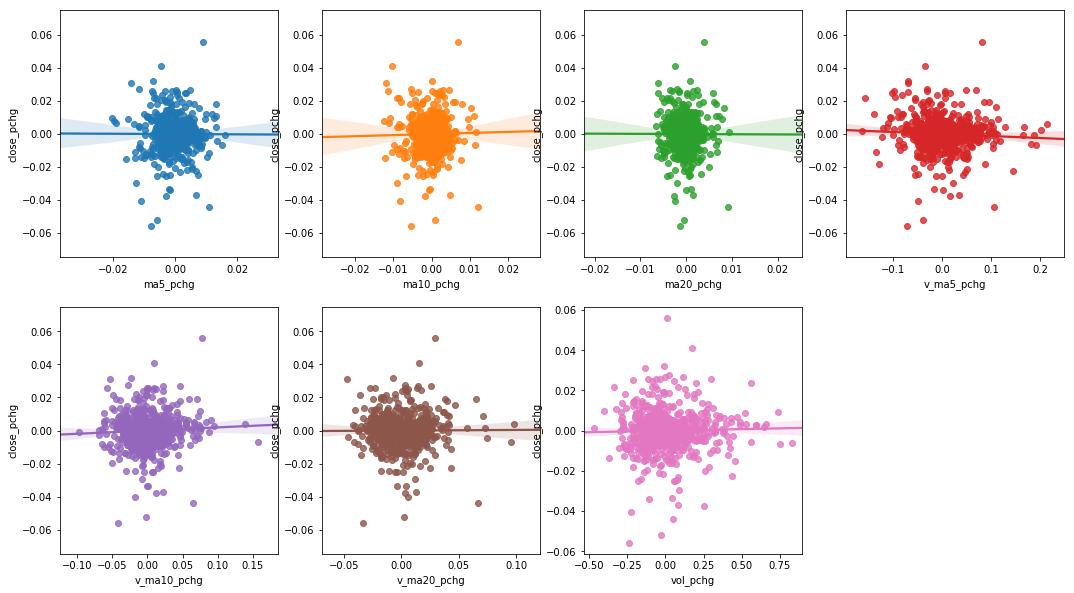

In [9]:

# 通过对象绘图
fig=plt.figure(figsize=(18, 10))
ax1=fig.add_subplot(2,4,1)
ax2=fig.add_subplot(2,4,2)
ax3=fig.add_subplot(2,4,3)
ax4=fig.add_subplot(2,4,4)
ax5=fig.add_subplot(2,4,5)
ax6=fig.add_subplot(2,4,6)
ax7=fig.add_subplot(2,4,7)

# ax1.scatter(ma5_pchg_close_pct.ma5_pchg, ma5_pchg_close_pct.close_pchg)

sns.regplot(x="ma5_pchg", y="close_pchg", data=ma5_pchg_close_pct, ax = ax1)
sns.regplot(x="ma10_pchg", y="close_pchg", data=ma10_pchg_close_pct, ax = ax2)
sns.regplot(x="ma20_pchg", y="close_pchg", data=ma20_pchg_close_pct, ax = ax3)
sns.regplot(x="v_ma5_pchg", y="close_pchg", data=v_ma5_pchg_close_pct, ax = ax4)
sns.regplot(x="v_ma10_pchg", y="close_pchg", data=v_ma10_pchg_close_pct, ax = ax5)
sns.regplot(x="v_ma20_pchg", y="close_pchg", data=v_ma20_pchg_close_pct, ax = ax6)
sns.regplot(x="vol_pchg", y="close_pchg", data=vol_pchg_close_pct, ax = ax7)

If we wanted to instead try a random forest to predict tomorrow's open, it'd be mostly copy-paste:

In [11]:
"""new"""
from sklearn.ensemble import RandomForestRegressor

y = outcomes.close_pchg
X = features
Xy = X.join(y).dropna()

# y = Xy[y.name]
# X = Xy[X.columns]
# print(y.shape)
# print(X.shape)

# model = RandomForestRegressor(max_features=3)
# model.fit(X,y)
# print("Model Score: "+ str(model.score(X,y)))

# print("Feature Importance: ")
# pd.Series(model.feature_importances_,index=X.columns)\
# .sort_values(ascending=False)

This yields a vastly improved RSQ but note that it is almost certainly ridiculously overfitted, as random forests are prone to do.

We'll cover ways to systematically avoid allowing the model to overfit in future posts, but that requires going a bit further down the rabbit hole.

Side note: in this example (and often, in real life) we've mixed together all observations from AAPL and CSCO into one dataset. We could have alternatively trained two different models for the two symbols, which may have achieved better fit, but almost certainly at the cost of worse generalization out of sample. The bias-variance trade-off in action!

# Prediction

Once the model is trained, it becomes a one-liner to make predictions from a set of feature values. In this case, we'll simply feed the same X values used to train the model, but in live usage, of course, we'd want to apply the trained model to new X values.

In [12]:
"""new"""
X.dropna(inplace=True)
model_pred = pd.Series(model.predict(X.dropna()),index=X.index)

In [13]:
model_pred_df = pd.DataFrame(model_pred)
model_pred_df.columns = ['predicted']
outcomes.head()

,close_pchg
date,
2017-01-04,0.0073
2017-01-05,0.0021
2017-01-06,-0.0035
2017-01-09,0.0054
2017-01-10,-0.0030


In [14]:
outcomes.reset_index(inplace=True)
model_pred_df.reset_index(inplace=True)
predicted_results = model_pred_df.merge(outcomes)
sh.tail(2)

,open,high,close,low,volume,close_diff,close_pchg,ma5,ma10,ma20,...,v_ma20,vol_pchg,ma5_pchg,ma10_pchg,ma20_pchg,v_ma5_pchg,v_ma10_pchg,v_ma20_pchg,day_of_week,day_of_month
date,,,,,,,,,,,,,,,,,,,,,
2019-07-04,3015.68,3024.50,3005.25,2991.91,1944151.38,-10.01,-0.0033,3017.646,3005.350,2952.197,...,2130390.87,-0.084227,0.000561,0.000604,0.002442,-0.000931,-0.042721,0.003026,4,4
2019-07-05,3004.74,3014.85,3011.06,2990.92,1567554.25,5.81,0.0019,3024.082,3006.258,2961.360,...,2120236.38,-0.193708,0.002133,0.000302,0.003104,-0.023423,-0.060160,-0.004766,5,5


In [15]:
predicted_results['date_close_pchg'] = predicted_results['date'].shift(-1)
predicted_results['close_pchg'] = predicted_results['close_pchg'].shift(-1)

In [16]:
predicted_results['count_correct'] = predicted_results['predicted']*predicted_results['close_pchg']
predicted_results['count_correct'] = predicted_results['count_correct'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
right_wrong = predicted_results.groupby(['count_correct']).count()
right_wrong['predicted'].values[2]/right_wrong.sum()[0]

0.5238879736408567

In [17]:
predicted_results.tail(10)

,date,predicted,close_pchg,date_close_pchg,count_correct
597,2019-06-24,0.000299,-0.0087,2019-06-25,-1
598,2019-06-25,-0.001528,-0.0019,2019-06-26,1
599,2019-06-26,-0.002886,0.0069,2019-06-27,-1
600,2019-06-27,-0.000672,-0.0060,2019-06-28,1
601,2019-06-28,0.002727,0.0222,2019-07-01,1
602,2019-07-01,0.002275,-0.0003,2019-07-02,-1
603,2019-07-02,0.002024,-0.0094,2019-07-03,-1
604,2019-07-03,0.002152,-0.0033,2019-07-04,-1
605,2019-07-04,-0.002054,0.0019,2019-07-05,-1
606,2019-07-05,-0.002973,NaN,NaN,0


In [30]:
1.5*(1.1)

1.6500000000000001

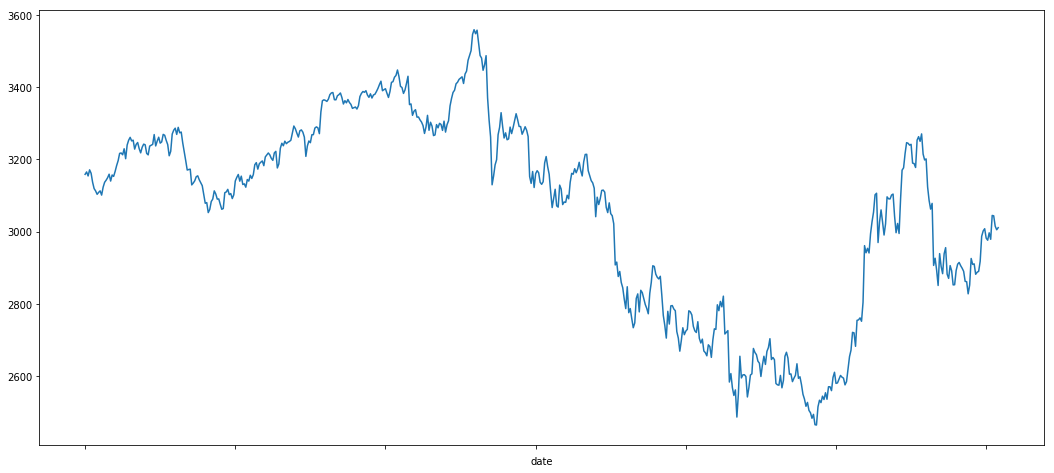

In [18]:
sh['close'].plot(figsize = (18, 8))

In [19]:
predicted_results.tail(10)

,date,predicted,close_pchg,date_close_pchg,count_correct
597,2019-06-24,0.000299,-0.0087,2019-06-25,-1
598,2019-06-25,-0.001528,-0.0019,2019-06-26,1
599,2019-06-26,-0.002886,0.0069,2019-06-27,-1
600,2019-06-27,-0.000672,-0.0060,2019-06-28,1
601,2019-06-28,0.002727,0.0222,2019-07-01,1
602,2019-07-01,0.002275,-0.0003,2019-07-02,-1
603,2019-07-02,0.002024,-0.0094,2019-07-03,-1
604,2019-07-03,0.002152,-0.0033,2019-07-04,-1
605,2019-07-04,-0.002054,0.0019,2019-07-05,-1
606,2019-07-05,-0.002973,NaN,NaN,0


In [20]:
right_wrong

,date,predicted,close_pchg,date_close_pchg
count_correct,,,,
-1,287,287,287,287
0,2,2,1,1
1,318,318,318,318


Let me pause here to emphasize the most critical point to understand about this framework. Read this twice!

The date of a feature row represents the day when a value would be known after that day's trading, using the feature value date as T=0. The date of an outcome row represents what will happen in the n days following that date.

- Predictions are indexed to the date of the evening when the model could have been run. 

In other words, the prediction indexed to 2016-12-23 represents what the model believes will happen in some time period after 12/23. In practical usage, we can't start using the trading signal until T+1 (since predictions are generated after markets are closed on T+0).

# 模型连错四次的概率？

In [21]:
predicted_results['accum_counts'] = predicted_results['count_correct'].cumsum()

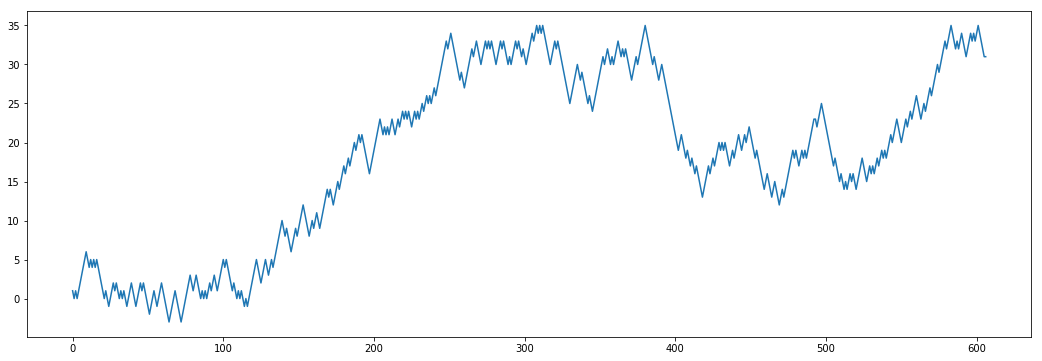

In [22]:
predicted_results['accum_counts'].plot(figsize = (18, 6))

In [23]:
predicted_results

,date,predicted,close_pchg,date_close_pchg,count_correct,accum_counts
0,2017-01-06,0.000133,0.0054,2017-01-09,1,1
1,2017-01-09,0.000317,-0.0030,2017-01-10,-1,0
2,2017-01-10,-0.000372,-0.0079,2017-01-11,1,1
3,2017-01-11,0.000128,-0.0056,2017-01-12,-1,0
4,2017-01-12,-0.000319,-0.0021,2017-01-13,1,1
5,2017-01-13,-0.000426,-0.0030,2017-01-16,1,2
6,2017-01-16,0.000800,0.0017,2017-01-17,1,3
7,2017-01-17,0.000717,0.0014,2017-01-18,1,4
8,2017-01-18,-0.000945,-0.0038,2017-01-19,1,5
9,2017-01-19,0.000850,0.0070,2017-01-20,1,6


In [24]:
bad_dates = []
for i, item in enumerate(predicted_results['count_correct']):
    if i >= 5:
        if predicted_results['accum_counts'][i] - predicted_results['accum_counts'][i-5] < -4: # 连续错四次
            bad_date = predicted_results['date'][i]
            bad_dates.append(bad_date)

In [25]:
predicted_results.head(25)

,date,predicted,close_pchg,date_close_pchg,count_correct,accum_counts
0,2017-01-06,0.000133,0.0054,2017-01-09,1,1
1,2017-01-09,0.000317,-0.0030,2017-01-10,-1,0
2,2017-01-10,-0.000372,-0.0079,2017-01-11,1,1
3,2017-01-11,0.000128,-0.0056,2017-01-12,-1,0
4,2017-01-12,-0.000319,-0.0021,2017-01-13,1,1
5,2017-01-13,-0.000426,-0.0030,2017-01-16,1,2
6,2017-01-16,0.000800,0.0017,2017-01-17,1,3
7,2017-01-17,0.000717,0.0014,2017-01-18,1,4
8,2017-01-18,-0.000945,-0.0038,2017-01-19,1,5
9,2017-01-19,0.000850,0.0070,2017-01-20,1,6


In [26]:
print(bad_dates)

['2017-02-13', '2017-04-17', '2017-10-31', '2018-01-23', '2018-01-24', '2018-04-27', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-08-06', '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-27', '2018-08-28', '2018-08-29', '2018-11-26', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31']


In [27]:
print("连续预测错误等于或超过4天的天数：", len(bad_dates))
print("总天数：", len(predicted_results))

连续预测错误等于或超过4天的天数： 23
总天数： 607


In [28]:
print("因此，连续预测错误等于或超过4天的情况发生的概率为：", str(round(len(bad_dates)/len(predicted_results)*100, 2))+"%")

因此，连续预测错误等于或超过4天的情况发生的概率为： 3.79%


# Summary

This post presented the concept of organizing data into a features dataframe and outcome dataframe, and then showed how simple it is to join these two dataframes together to train a model.

True, the convention may take a few examples to get used to. However, after trial and error, I've found this to be the most error-resistant, flexible, and high-performance way to go.

In the next post, I will share some methods of feature engineering and feature selection.

# One last thing...

If you've found this post useful, please follow @data2alpha on twitter and forward to a friend or colleague who may also find this topic interesting.

Finally, take a minute to leave a comment below - either to discuss this post or to offer an idea for future posts. Thanks for reading!